# Building a Transformer Encoder for Text Classification
## 1 - Introduction
In this notebook, you'll build a **Transformer Encoder** from scratch and apply it to sentiment analysis—classifying movie reviews as positive or negative. 

### What is a Transformer Encoder?
A Transformer encoder is a neural network architecture that transforms input text into rich numerical representations. It reads an entire sequence of words at once and produces a contextualized representation for each word—meaning each word's representation contains information about how it relates to all other words in the sequence. Think of it as a sophisticated reading comprehension system that understands not just individual words, but their meanings in context.

This hands-on implementation will deepen your understanding of how encoder models work and why they've become the backbone of models like BERT, RoBERTa, and other state-of-the-art NLP systems.

### What You'll Build
Starting from the attention mechanisms you've already mastered, you'll construct:
1. A complete encoder block with multi-head attention and feed-forward layers
2. A stack of encoder layers that progressively refine text representations
3. A classification head that uses these representations for sentiment analysis
4. A training pipeline that achieves strong performance on real movie reviews

By the end of this notebook, you'll have implemented the same encoder architecture that, when pre-trained on massive text corpora, becomes BERT—one of the most important breakthroughs in modern NLP.

### 1.1 Importing Necessary Modules

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from collections import Counter
import re
import random

import helper_utils

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## 2 - Building the Encoder Block
### 2.1 Understanding the Encoder Architecture

The encoder block is the fundamental building block of the Transformer encoder—a sophisticated text processing unit that refines word representations through attention and feed-forward mechanisms.

<div align="center">
  <img src="images/encoder-block.svg" alt="Encoder Block Architecture" width="80%">
</div>

#### Key Components

**Multi-Head Attention**: Allows every word to gather information from all other words, with multiple parallel attention heads learning different types of relationships.

**Feed-Forward Network**: Applies the same neural network independently to each position, adding non-linearity through two linear layers with ReLU activation.

**Residual Connections** (green dashed lines): Create a direct path from input to output by adding the original input to each sub-layer's output. This preserves information and enables gradient flow through deep networks. Mathematically: `Output = Input + SubLayer(Input)`

**Layer Normalization**: Stabilizes training by normalizing activations before each sub-layer.

### 2.2 Implementing the Encoder Block

Let's implement the encoder block, bringing together all these components into a modular unit that can be stacked to create increasingly sophisticated representations. Each additional layer captures more abstract patterns and longer-range dependencies.

**Note:** This is a simplified version of an Encoder Layer. PyTorch's implementation includes additional parameters for more flexibility.

In [17]:
class EncoderBlock(nn.Module):
    def __init__(self, d_model=4, nhead=1, ffn_mult=4):
        super().__init__()
        # Layer normalization before attention
        self.ln1 = nn.LayerNorm(d_model)
        # Multi-head self-attention
        self.mha = nn.MultiheadAttention(d_model, nhead, batch_first=True)
        # Layer normalization before feed-forward
        self.ln2 = nn.LayerNorm(d_model)        
        # Feed-forward network with expansion
        hidden = ffn_mult * d_model
        self.ffn = nn.Sequential(
            nn.Linear(d_model, hidden),
            nn.ReLU(),
            nn.Linear(hidden, d_model)
        )
    
    def forward(self, x):        
        # First sub-layer: Multi-head attention with residual connection
        x_norm = self.ln1(x)
        attn_out, _ = self.mha(x_norm, x_norm, x_norm)
        x = x + attn_out  # Residual connection
        
        # Second sub-layer: Feed-forward with residual connection
        ffn_in = self.ln2(x)
        ffn_out = self.ffn(ffn_in)
        x = x + ffn_out  # Residual connection
        
        return x

### 2.3 Testing the Encoder Block
Let's create a simple example to understand how the encoder block transforms input data. You'll create a small input tensor and pass it through the encoder to see the output shape and values.

In [18]:
# Create a simple encoder block with small dimensions for demonstration
encoder_demo = EncoderBlock(d_model=4, nhead=1, ffn_mult=4)

# Create a sample input: (batch_size=2, sequence_length=3, d_model=4)
sample_input = torch.randn(2, 3, 4)

print("Input shape:", sample_input.shape)
print("Input tensor:\n", sample_input)

# Pass through encoder block
output = encoder_demo(sample_input)

print("\nOutput shape:", output.shape)
print("Output tensor:\n", output)

# Notice that the shape remains the same
print("\nShape preserved: Input shape == Output shape:", sample_input.shape == output.shape)

Input shape: torch.Size([2, 3, 4])
Input tensor:
 tensor([[[ 1.3032,  0.4879,  1.1340, -0.3556],
         [ 0.3618,  1.9993,  0.6630,  0.7047],
         [-0.9291,  0.2762, -0.5389,  0.4626]],

        [[-0.8719, -0.0271, -0.3532,  1.4639],
         [ 1.2554, -0.7150,  0.8539,  0.5130],
         [ 0.5397,  0.5655,  0.5058,  0.2225]]])

Output shape: torch.Size([2, 3, 4])
Output tensor:
 tensor([[[ 1.0026,  0.2121,  1.4273,  0.1655],
         [ 0.4462,  1.7480,  0.8359,  1.2673],
         [-0.9382, -0.1464, -0.3801,  0.8587]],

        [[-0.8144, -0.2512, -0.4787,  1.6496],
         [ 0.5040, -1.2128,  0.8961,  0.6108],
         [ 0.3139,  0.4903,  0.5755,  0.6699]]], grad_fn=<AddBackward0>)

Shape preserved: Input shape == Output shape: True


### 2.4 Positional Encoding

#### Sinusoidal Positional Encodings

In the previous lab, you used learned positional embeddings. In this lab, you'll use a different approach: **sinusoidal positional encodings**—the method introduced in the original Transformer paper ("Attention is All You Need").

Positional encoding adds a unique "position signature" to each token's embedding, like GPS coordinates for words. This tells the model not just *what* each word is, but *where* it appears in the sequence.

<div align="center">
<img src="images/positional-encoding.svg" alt="Positional Encoding in Encoder" width="70%">
</div>

The encoder uses **sinusoidal functions** (sine and cosine waves at different frequencies) to create these position signatures:
- Each position gets a unique pattern—like a mathematical fingerprint
- The model can learn relative distances between any two positions
- Patterns naturally extend to sequences longer than training data

This enables the model to understand both **absolute position** ("3rd word") and **relative position** ("4 positions apart"), crucial for understanding grammar and long-range dependencies.

The key advantages of the sinusoidal approach are:
- Zero learnable parameters
- Can generalize to sequences longer than those seen during training
- Mathematical properties that help the model learn relative positions
- Has become the standard in production transformer implementations

In [19]:
class PositionalEncoding(nn.Module):
    """
    Adds positional information to token embeddings using sinusoidal patterns.
    
    Since transformers don't have inherent notion of sequence order (unlike RNNs),
    we add positional encodings to give the model information about where each
    token appears in the sequence.
    """
    def __init__(self, max_len, d_model):
        """
        Initialize positional encoding matrix.
        
        Args:
            max_len (int): Maximum sequence length the model will handle
                          (e.g., 100 for sentences up to 100 tokens)
            d_model (int): Dimension of the model's embeddings 
                          (e.g., 256 or 512 - must match embedding size)
        
        Creates a fixed sinusoidal pattern matrix of shape [max_len, d_model]
        where each row represents the positional encoding for that position.
        """
        super().__init__()
        self.max_len = max_len
        self.d_model = d_model
        
        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        
        # Create div_term for the sinusoidal pattern
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           -(torch.log(torch.tensor(10000.0)) / d_model))
        
        # Apply sin to even indices
        pe[:, 0::2] = torch.sin(position * div_term)
        # Apply cos to odd indices  
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Register as buffer (not trained, but saved with model)
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        """
        Return positional encodings for the input sequence length.
        
        Args:
            x (Tensor): Token embeddings of shape [batch_size, seq_len, d_model]
                       where seq_len <= max_len from initialization
        
        Returns:
            Tensor: Positional encodings of shape [batch_size, seq_len, d_model]
                   (same shape as input, ready to be added to embeddings)
        
        Example:
            If x represents embeddings for "I love cats" (3 tokens):
            - Input x shape: [batch_size, 3, 256]
            - Output shape: [batch_size, 3, 256]
            - Returns positions 0, 1, 2 encoded as 256-dim vectors
        """
        seq_len = x.size(1)
        # Return ONLY the positional encodings (not added to x)
        # The addition happens in the model's forward method
        return self.pe[:, :seq_len, :]

Let's visualize how positional encoding works:

Input embeddings shape: torch.Size([2, 10, 128])
Input embeddings mean: 0.0051

Output shape (unchanged): torch.Size([1, 10, 100])
Output mean (slightly different): 0.4773


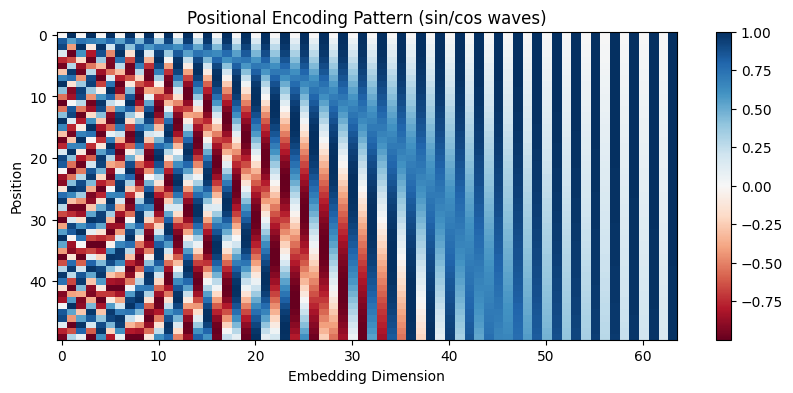

In [20]:
# Example: Create positional encoding and visualize
d_model = 128
max_len = 100
pos_encoder = PositionalEncoding(d_model, max_len)

# Create dummy embeddings for a batch of sequences
batch_size = 2
seq_len = 10
dummy_embeddings = torch.randn(batch_size, seq_len, d_model)

print(f"Input embeddings shape: {dummy_embeddings.shape}")
print(f"Input embeddings mean: {dummy_embeddings.mean():.4f}")

# Apply positional encoding
output = pos_encoder(dummy_embeddings)
print(f"\nOutput shape (unchanged): {output.shape}")
print(f"Output mean (slightly different): {output.mean():.4f}")

# Visualize the positional encoding pattern for first 50 positions and dimensions
import matplotlib.pyplot as plt
pe_matrix = pos_encoder.pe[0, :50, :64].numpy()
plt.figure(figsize=(10, 4))
plt.imshow(pe_matrix, cmap='RdBu', aspect='auto')
plt.colorbar()
plt.xlabel('Embedding Dimension')
plt.ylabel('Position')
plt.title('Positional Encoding Pattern (sin/cos waves)')
plt.show()

### Understanding the Positional Encoding Visualization

This heatmap shows the positional encoding values added to embeddings:

- **X-axis**: Embedding dimensions (0-63)
- **Y-axis**: Sequence positions (0-49)  
- **Colors**: Blue = positive values, Red = negative values, White = near zero

**Key Patterns**:
- **Left side**: Fast alternating patterns (high frequency) - capture local/nearby position information
- **Right side**: Smooth gradients (low frequency) - capture global/long-range position information
- **Each row**: Has a unique pattern - this is how position 5 is distinguished from position 45

The varying frequencies (fast to slow) allow the model to understand both local word relationships and long-distance dependencies in the sequence. Each position gets a unique "fingerprint" that the model learns to interpret.

### 2.5 Understanding Padding Masks in Transformers

#### What is Padding and Why Do We Need It?

In real-world NLP applications, sentences have varying lengths. To process them efficiently in batches, we need to make all sequences the same length by adding **padding tokens**. However, these padding tokens shouldn't contribute to our model's understanding of the actual text.

In [21]:
def create_padding_mask(seq, pad_idx=0):
    """
    Creates a boolean mask for padding tokens.
    
    Args:
        seq: Input sequence tensor [batch_size, seq_len]
        pad_idx: Index used for padding (typically 0)
    
    Returns:
        Boolean tensor where True = padding, False = real token
    """
    return seq == pad_idx

# Example usage

# Sample batch with padding
batch = torch.tensor([
    [2, 15, 89, 234, 3, 0, 0, 0],   # 5 real tokens, 3 padding
    [2, 45, 67, 89, 123, 234, 3, 0], # 7 real tokens, 1 padding
    [2, 56, 3, 0, 0, 0, 0, 0],       # 3 real tokens, 5 padding
])

# Create padding mask
padding_mask = create_padding_mask(batch, pad_idx=0)
print("Input batch shape:", batch.shape)
print("\nPadding mask:")
print(padding_mask)
print("\nTrue = padding position, False = real token")

Input batch shape: torch.Size([3, 8])

Padding mask:
tensor([[False, False, False, False, False,  True,  True,  True],
        [False, False, False, False, False, False, False,  True],
        [False, False, False,  True,  True,  True,  True,  True]])

True = padding position, False = real token


## 3 - Data Preparation

### 3.1 Loading the IMDB Dataset

The IMDB movie review dataset is a standard benchmark for sentiment analysis. It contains 50,000 movie reviews split evenly into training and test sets, with each set containing 25,000 positive and 25,000 negative reviews.

Let's download and prepare the dataset.

In [22]:
# Load the dataset with default settings (2000 train, 500 test samples)
train_reviews, train_labels, test_reviews, test_labels = helper_utils.get_imdb_data()

IMDB dataset already downloaded

Loading training data...
Loading 1000 positive training reviews...
Loading 1000 negative training reviews...
Total training reviews loaded: 2000

Loading test data...
Loading 250 positive test reviews...
Loading 250 negative test reviews...
Total test reviews loaded: 500


### 3.4 Exploring the Data

Let's examine the loaded data to understand what you're working with:

In [23]:
helper_utils.print_data_statistics(train_reviews, train_labels, test_reviews, test_labels)


=== Dataset Statistics ===
Training set:
  Total reviews: 2000
  Positive reviews: 1000
  Negative reviews: 1000

Test set:
  Total reviews: 500
  Positive reviews: 250
  Negative reviews: 250

=== Sample Reviews ===

--- Positive Review Example ---
Label: Positive
Text (first 400 chars): Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole si...

--- Negative Review Example ---
Label: Negative
Text (first 400 chars): Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singe

## 4 - Text Processing and Dataset Creation

### 4.1 Building a Tokenizer

Before you can feed text into the neural network, you need to convert words into numbers. You'll create a tokenizer that builds a vocabulary from the training data and converts text into sequences of token indices.

In [24]:
class IMDBTokenizer:
    def __init__(self, vocab_size=10000):
        self.vocab_size = vocab_size
        # Special tokens
        self.word_to_idx = {'<pad>': 0, '<unk>': 1, '<sos>': 2, '<eos>': 3}
        self.idx_to_word = {0: '<pad>', 1: '<unk>', 2: '<sos>', 3: '<eos>'}
        self.word_freq = Counter()
    
    def build_vocab(self, texts, min_freq=2):
        """Build vocabulary from texts"""
        print("Building vocabulary...")
        
        # Count word frequencies
        for text in texts:
            words = self.tokenize(text)
            self.word_freq.update(words)
        
        # Get most common words (reserve 4 spots for special tokens)
        most_common = self.word_freq.most_common(self.vocab_size - 4)
        
        # Add words to vocabulary if they meet minimum frequency
        idx = 4  # Start after special tokens
        for word, freq in most_common:
            if freq >= min_freq:
                self.word_to_idx[word] = idx
                self.idx_to_word[idx] = word
                idx += 1
        
        print(f"Vocabulary size: {len(self.word_to_idx)}")
    
    def tokenize(self, text):
        """Simple tokenization - split text into words"""
        text = text.lower()
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        # Keep only letters and spaces (remove all punctuation)
        text = re.sub(r'[^a-z\s]', '', text)
        words = text.split()
        return words
        
    def encode(self, text, max_len=256):
        """Convert text to indices"""
        words = self.tokenize(text)[:max_len-2]  # Leave space for SOS/EOS tokens
        
        # Start with SOS token
        indices = [2]
        
        # Convert words to indices
        for word in words:
            if word in self.word_to_idx:
                indices.append(self.word_to_idx[word])
            else:
                indices.append(1)  # Unknown word -> UNK token
        
        # Add EOS token
        indices.append(3)
        
        # Pad sequence to max_len
        while len(indices) < max_len:
            indices.append(0)  # Pad token
        
        return indices[:max_len]  # Ensure exactly max_len

### 4.2 Creating and Testing the Tokenizer

Let's create the tokenizer and test it with sample text to see how it works:

In [25]:
# Create tokenizer
tokenizer = IMDBTokenizer(vocab_size=5000)

# Build vocabulary from training reviews
tokenizer.build_vocab(train_reviews, min_freq=2)

# Test tokenizer with a sample sentence
sample_text = "This movie was absolutely fantastic! I loved every minute of it."
print("Original text:", sample_text)

# Tokenize the text
tokens = tokenizer.tokenize(sample_text)
print("\nTokenized:", tokens)

# Encode to indices
encoded = tokenizer.encode(sample_text, max_len=20)
print("\nEncoded (max_len=20):", encoded)

# Decode back to words to verify
decoded_words = [tokenizer.idx_to_word.get(idx, '<unk>') for idx in encoded]
print("\nDecoded words:", decoded_words)

# Show some vocabulary statistics
print(f"\nVocabulary Statistics:")
print(f"Total unique words in vocab: {len(tokenizer.word_to_idx)}")
print(f"Most common words: {tokenizer.word_freq.most_common(10)}")

Building vocabulary...
Vocabulary size: 5000
Original text: This movie was absolutely fantastic! I loved every minute of it.

Tokenized: ['this', 'movie', 'was', 'absolutely', 'fantastic', 'i', 'loved', 'every', 'minute', 'of', 'it']

Encoded (max_len=20): [2, 13, 16, 15, 404, 662, 12, 351, 169, 789, 7, 11, 3, 0, 0, 0, 0, 0, 0, 0]

Decoded words: ['<sos>', 'this', 'movie', 'was', 'absolutely', 'fantastic', 'i', 'loved', 'every', 'minute', 'of', 'it', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

Vocabulary Statistics:
Total unique words in vocab: 5000
Most common words: [('the', 25571), ('a', 12315), ('and', 11998), ('of', 11169), ('to', 10196), ('is', 7958), ('in', 6892), ('it', 5886), ('i', 5734), ('this', 5618)]


### 4.3 Creating PyTorch Dataset

Now you'll create a PyTorch Dataset class that will handle the data loading and preprocessing for training:

In [26]:
class IMDBDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len=256):
        """
        Initialize IMDB dataset
        Args:
            reviews: List of review texts
            labels: List of labels (0 or 1)
            tokenizer: Tokenizer object for encoding text
            max_len: Maximum sequence length
        """
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.data = []
        self.labels = []
        
        print(f"Processing {len(reviews)} reviews...")
        
        # Encode all reviews
        for review, label in zip(reviews, labels):
            encoded = tokenizer.encode(review, max_len)
            self.data.append(encoded)
            self.labels.append(label)
        
        # Convert to tensors
        self.data = torch.LongTensor(self.data)
        self.labels = torch.LongTensor(self.labels)
        
        print(f"Dataset created with shape: {self.data.shape}")
    
    def __len__(self):
        """Return the size of the dataset"""
        return len(self.data)
    
    def __getitem__(self, idx):
        """Get a single item from the dataset"""
        return self.data[idx], self.labels[idx]

### 4.4 Creating Train and Test Datasets

Let's create the dataset objects and data loaders for training:


In [27]:
# Create datasets
max_seq_length = 256  # Maximum sequence length

print("Creating training dataset...")
train_dataset = IMDBDataset(train_reviews, train_labels, tokenizer, max_len=max_seq_length)

print("\nCreating test dataset...")
test_dataset = IMDBDataset(test_reviews, test_labels, tokenizer, max_len=max_seq_length)

# Create data loaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nData loaders created:")
print(f"  Training batches: {len(train_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Examine a single batch
sample_batch, sample_labels = next(iter(train_loader))
print(f"\nSample batch shape: {sample_batch.shape}")
print(f"Sample labels shape: {sample_labels.shape}")
print(f"First sequence in batch (first 20 tokens): {sample_batch[0, :20].tolist()}")
print(f"Label for first sequence: {sample_labels[0].item()}")

Creating training dataset...
Processing 2000 reviews...
Dataset created with shape: torch.Size([2000, 256])

Creating test dataset...
Processing 500 reviews...
Dataset created with shape: torch.Size([500, 256])

Data loaders created:
  Training batches: 63
  Test batches: 16

Sample batch shape: torch.Size([32, 256])
Sample labels shape: torch.Size([32])
First sequence in batch (first 20 tokens): [2, 4, 1227, 9, 1893, 6, 4, 2768, 9, 1, 824, 12, 344, 14, 11, 1, 1, 1, 7, 4]
Label for first sequence: 1


## 5 - Building the Sentiment Classification Model with Custom Encoder

### 5.1 Complete Model Architecture

Now you'll combine the encoder blocks into a complete model for sentiment classification. The model will:
1. Convert token indices to embeddings
2. Add positional embeddings to preserve sequence order
3. Pass through multiple encoder blocks
4. Pool the sequence representation
5. Classify into positive or negative sentiment

In [28]:
class IMDBSentimentModelWithCustomEncoder(nn.Module):
    def __init__(self, vocab_size, d_model=128, num_layers=2, max_len=512, dropout=0.1):
        """
        Sentiment classifier using stacked encoder blocks with positional encoding
        
        Args:
            vocab_size: Size of vocabulary
            d_model: Dimension of embeddings
            num_layers: Number of encoder blocks to stack (default: 2)
            max_len: Maximum sequence length for positional encoding (default: 512)
            dropout: Dropout probability for regularization (default: 0.1)
        """
        super().__init__()
        
        # Store d_model for debugging
        self.d_model = d_model
        
        # Convert word indices to vectors
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        
        # IMPORTANT: Make sure PositionalEncoding uses the SAME d_model
        self.positional_encoding = PositionalEncoding(max_len, d_model)  # d_model must match!
        
        # Dropout after embeddings + positional encoding (standard practice)
        self.dropout = nn.Dropout(dropout)
        
        # Stack multiple encoder blocks
        self.encoder_layers = nn.ModuleList([
            EncoderBlock(d_model=d_model, nhead=8, ffn_mult=4) 
            for _ in range(num_layers)
        ])
        
        # Simple classifier
        self.classifier = nn.Linear(d_model, 2)  # 2 classes: negative and positive
    
    def forward(self, x):
        """
        Forward pass
        
        Args:
            x: Input tensor of token indices (batch_size, seq_len)
        Returns:
            Classification logits (batch_size, 2)
        """
        # Step 1: Convert tokens to embeddings
        x = self.embedding(x)  # Shape: (batch_size, seq_len, d_model)
        
        # Step 2: Add positional encoding to embeddings
        pos_encoding = self.positional_encoding(x)
        
        x = x + pos_encoding
        
        # Step 3: Apply dropout for regularization
        x = self.dropout(x)
        
        # Step 4: Pass through each encoder layer sequentially
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x)  # Shape: (batch_size, seq_len, d_model)
        
        # Step 5: Simple pooling - average all tokens
        x = x.mean(dim=1)  # Shape: (batch_size, d_model)
        
        # Step 6: Classify
        output = self.classifier(x)  # Shape: (batch_size, 2)
        
        return output

### 5.2 Creating and Testing the Model

Let's create an instance of the model and test it with a sample batch:

In [29]:
# Get vocabulary size
vocab_size = len(tokenizer.word_to_idx)

# Create the model
model = IMDBSentimentModelWithCustomEncoder(
    vocab_size=vocab_size,
    d_model=128,
    num_layers = 2
)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())

print(f"Model created: IMDBSentimentModel")
print(f"Total learnable parameters: {total_params:,}")

Model created: IMDBSentimentModel
Total learnable parameters: 1,036,802


### 5.3 Understanding the Forward Pass

Let's trace through the model step by step with a small example:

In [30]:
# Create a simple input: batch of 2 sequences, each with 5 tokens
tiny_input = torch.tensor([
    [2, 45, 23, 67, 3],  # First review: <sos>, word45, word23, word67, <eos>
    [2, 12, 89, 34, 3]   # Second review: <sos>, word12, word89, word34, <eos>
])
print("=== Step-by-step Forward Pass ===\n")
print("Input (token indices):")
print(tiny_input)
print("Shape:", tiny_input.shape, "\n")

# Step through the model manually
with torch.no_grad():
    # Step 1: Embedding
    embedded = model.embedding(tiny_input)
    print("Step 1 - After embedding:")
    print("  Shape:", embedded.shape)
    print("  Each token is now a vector of size", embedded.shape[-1])
    
    # Step 2: Pass through encoder layers
    x = embedded
    print(f"\nStep 2 - Passing through {len(model.encoder_layers)} encoder layer(s):")
    for i, encoder_layer in enumerate(model.encoder_layers):
        x = encoder_layer(x)
        print(f"  After encoder layer {i+1}:")
        print(f"    Shape: {x.shape}")
        if i == 0:
            print("    Note: shape is unchanged, but representations are refined")
    
    encoded = x
    print(f"\nAfter all encoder layers:")
    print(f"  Final encoded shape: {encoded.shape}")
    print("  Each token now has a contextualized representation")
    
    # Step 3: Pooling
    pooled = encoded.mean(dim=1)
    print("\nStep 3 - After averaging across sequence:")
    print("  Shape:", pooled.shape)
    print("  Now we have one vector per review")
    
    # Step 4: Classification
    output = model.classifier(pooled)
    print("\nStep 4 - Final classification scores:")
    print("  Shape:", output.shape)
    print("  Raw scores (logits):", output)
    
    # Convert to probabilities
    probs = torch.softmax(output, dim=1)
    print("\n  Probabilities [negative, positive]:")
    for i, p in enumerate(probs):
        print(f"    Review {i}: [{p[0]:.3f}, {p[1]:.3f}]")

=== Step-by-step Forward Pass ===

Input (token indices):
tensor([[ 2, 45, 23, 67,  3],
        [ 2, 12, 89, 34,  3]])
Shape: torch.Size([2, 5]) 

Step 1 - After embedding:
  Shape: torch.Size([2, 5, 128])
  Each token is now a vector of size 128

Step 2 - Passing through 2 encoder layer(s):
  After encoder layer 1:
    Shape: torch.Size([2, 5, 128])
    Note: shape is unchanged, but representations are refined
  After encoder layer 2:
    Shape: torch.Size([2, 5, 128])

After all encoder layers:
  Final encoded shape: torch.Size([2, 5, 128])
  Each token now has a contextualized representation

Step 3 - After averaging across sequence:
  Shape: torch.Size([2, 128])
  Now we have one vector per review

Step 4 - Final classification scores:
  Shape: torch.Size([2, 2])
  Raw scores (logits): tensor([[ 0.2725, -0.0999],
        [ 0.2936, -0.3844]])

  Probabilities [negative, positive]:
    Review 0: [0.592, 0.408]
    Review 1: [0.663, 0.337]


### 5.4 Testing with Real Data
Let's test the model with actual review data:

In [31]:
# Get a batch from our data loader
sample_input, sample_labels = next(iter(train_loader))

print("Testing with real data:")
print(f"Batch shape: {sample_input.shape}")

# Forward pass
with torch.no_grad():
    output = model(sample_input)

# Get predictions
predictions = torch.argmax(output, dim=1)
accuracy = (predictions == sample_labels).float().mean()

print(f"\nResults on this batch (untrained model):")
print(f"  Accuracy: {accuracy:.1%}")
print(f"\nFirst 5 predictions vs actual:")
print("="*70)

for i in range(5):
    pred_label = "Positive" if predictions[i] == 1 else "Negative"
    true_label = "Positive" if sample_labels[i] == 1 else "Negative"
    correct = "✓" if predictions[i] == sample_labels[i] else "✗"
    
    # Decode the tokens back to words (first 30 tokens for brevity)
    tokens = sample_input[i][:30].tolist()
    # Remove padding tokens (0s) from the end
    tokens = [t for t in tokens if t != 0]
    # Convert token IDs back to words
    words = [tokenizer.idx_to_word.get(token_id, '<unk>') for token_id in tokens]
    # Join into sentence
    sentence_preview = ' '.join(words[:15]) + '...'  # Show first 15 words
    
    print(f"\nSample {i}:")
    print(f"  Text: {sentence_preview}")
    print(f"  Predicted: {pred_label}, Actual: {true_label} {correct}")

Testing with real data:
Batch shape: torch.Size([32, 256])

Results on this batch (untrained model):
  Accuracy: 43.8%

First 5 predictions vs actual:

Sample 0:
  Text: <sos> <unk> the only reason im giving this movie a instead of a is because...
  Predicted: Negative, Actual: Negative ✓

Sample 1:
  Text: <sos> having seen most of <unk> <unk> films i can say that this is his...
  Predicted: Negative, Actual: Positive ✗

Sample 2:
  Text: <sos> what a good movie at last a picture revealing a unknown side of rock...
  Predicted: Negative, Actual: Positive ✗

Sample 3:
  Text: <sos> this story is a complex and wonderful tale of the last <unk> of the...
  Predicted: Negative, Actual: Positive ✗

Sample 4:
  Text: <sos> while the british produced some hilarious and <unk> <unk> in the s <unk> <unk>...
  Predicted: Negative, Actual: Positive ✗


### 5.5 Model Summary

In [32]:
helper_utils.print_summary(model, vocab_size=vocab_size)

Device available: cuda

Model moved to cuda
Ready for training!

MODEL SUMMARY
Model: IMDBSentimentModelWithCustomEncoder
Vocabulary size: 5000
Embedding dimension: 128
Number of attention heads: 4
Total parameters: 1,036,802

The model is now ready to be trained!


## 6 - Training the Model

### 6.1 Setting Up Training Components

To train the model, you need to set up the loss function and optimizer. For binary classification, you'll use Cross Entropy Loss, and for optimization, you'll use Adam optimizer.

In [33]:
# Loss function for classification
criterion = nn.CrossEntropyLoss()

# Optimizer - Adam with learning rate 0.001
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("Training setup:")
print(f"  Loss function: CrossEntropyLoss")
print(f"  Optimizer: Adam")
print(f"  Learning rate: {learning_rate}")
print(f"  Batch size: {batch_size}")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Test samples: {len(test_dataset)}")

Training setup:
  Loss function: CrossEntropyLoss
  Optimizer: Adam
  Learning rate: 0.001
  Batch size: 32
  Training samples: 2000
  Test samples: 500


### 6.2 Evaluating Before Training

Let's first check how the untrained model performs on the test set:

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Evaluate untrained model
model.eval()
correct = 0
total = 0

print("Evaluating untrained model...")
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

initial_accuracy = 100 * correct / total
print(f"Initial Test Accuracy (before training): {initial_accuracy:.2f}%")

Evaluating untrained model...
Initial Test Accuracy (before training): 50.00%


### 6.3 Training The Model!

Now run the next cell to train your model with a custom Encoder.

In [35]:
# Train the model
history = helper_utils.train_model_decoder(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=5,
    device=device  # Optional, will auto-detect if not provided
)

Training on cuda


Epoch 1/5 [Test]: 100%|██████████| 16/16 [00:00<00:00, 156.59it/s, acc=50.0%]


  🎯 New best model! Test Acc: 50.00%
Epoch 1/5 Summary:
  Train - Loss: 0.7222, Acc: 49.20%
  Test  - Loss: 0.6958, Acc: 50.00%
--------------------------------------------------


Epoch 2/5 [Test]: 100%|██████████| 16/16 [00:00<00:00, 147.80it/s, acc=67.0%]


  🎯 New best model! Test Acc: 67.00%
Epoch 2/5 Summary:
  Train - Loss: 0.6746, Acc: 56.45%
  Test  - Loss: 0.6081, Acc: 67.00%
--------------------------------------------------


Epoch 3/5 [Test]: 100%|██████████| 16/16 [00:00<00:00, 130.58it/s, acc=70.8%]


  🎯 New best model! Test Acc: 70.80%
Epoch 3/5 Summary:
  Train - Loss: 0.5308, Acc: 73.35%
  Test  - Loss: 0.5604, Acc: 70.80%
--------------------------------------------------


Epoch 4/5 [Test]: 100%|██████████| 16/16 [00:00<00:00, 139.94it/s, acc=72.6%]


  🎯 New best model! Test Acc: 72.60%
Epoch 4/5 Summary:
  Train - Loss: 0.3747, Acc: 82.50%
  Test  - Loss: 0.5819, Acc: 72.60%
--------------------------------------------------


Epoch 5/5 [Test]: 100%|██████████| 16/16 [00:00<00:00, 141.45it/s, acc=74.4%]

  🎯 New best model! Test Acc: 74.40%
Epoch 5/5 Summary:
  Train - Loss: 0.2892, Acc: 88.10%
  Test  - Loss: 0.5621, Acc: 74.40%
--------------------------------------------------

Training completed! Best model restored from epoch 5
Best Test Accuracy: 74.40%


### 6.5 Visualizing Training Progress

Let's plot the training history to see how the model learned:

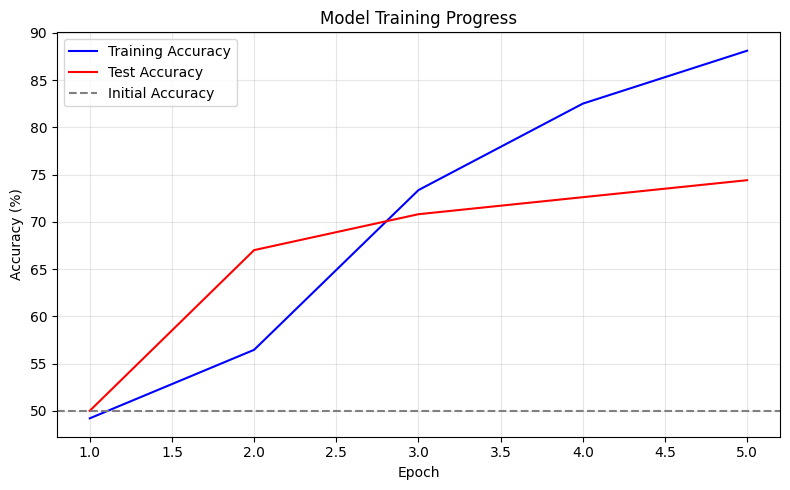

Accuracy Summary:
  Started at: 50.00% (untrained)
  Final test accuracy: 74.40%
  Total improvement: +24.40%


In [36]:
helper_utils.plot_training_history(history)

## 7 - Using PyTorch's Built-in Transformer Encoder
### 7.1 Creating a General-Purpose Encoder with PyTorch
Now that you understand the encoder architecture from building it yourself, let's leverage PyTorch's optimized implementation for a production-ready model. PyTorch provides `nn.TransformerEncoder` which handles all the complexity you've just implemented, but with additional optimizations for speed and memory efficiency.

#### A Versatile Encoder Design
The encoder we're building is designed to be versatile - it can be used standalone for tasks like classification, or as part of a larger encoder-decoder architecture for tasks like translation. This flexibility is achieved through a key design decision: **the encoder always returns both the encoded representation and the padding mask**.

**What is "Memory" in Transformer Context?**
In transformer terminology, "memory" refers to the encoded representation of the input sequence. It's called "memory" because:
- It contains all the learned contextual information from the input
- In encoder-decoder models, the decoder "remembers" and attends to this information
- Each position in the memory contains a rich, contextualized representation of the corresponding input token

#### The Encoder's Dual Output
Our encoder returns two crucial components:
1. **Memory** (`[batch_size, seq_len, d_model]`): The contextualized representations of all input tokens
2. **Padding Mask** (`[batch_size, seq_len]`): A boolean mask indicating which positions are padding

This dual output makes the encoder incredibly flexible:
- **For classification**: Use the memory with a pooling strategy and classification head
- **For translation**: Pass both memory and mask to a decoder
- **For sequence tagging**: Use the memory directly for token-level predictions

#### From Text to Encoded Representations: The Pipeline
Here's how our encoder processes text:
```
Input Text: "This movie is great"
         ↓
    [Tokenization]
         ↓
    Token IDs: [101, 2023, 3185, 2003, 2307, 0, 0]  (with padding)
         ↓
    [Token Embedding]
         ↓
    [Add Positional Encoding]
         ↓
    [Create Padding Mask]
         ↓
    [Transformer Encoder Stack]
         ↓
    Outputs:
    - Memory: Contextualized representations for all positions
    - Padding Mask: [True, True, True, True, True, False, False]
```

#### Key Design Features
**Built-in Padding Support:**
- The encoder automatically creates padding masks from input token IDs
- Assumes padding token ID is 0 (standard convention)
- Ensures padding tokens don't influence the attention mechanism

**Architectural Parameters:**
- `vocab_size`: Size of the token vocabulary
- `d_model`: Dimension of token representations (256 by default)
- `nhead`: Number of attention heads for multi-perspective learning
- `num_layers`: Depth of the encoder stack
- `dim_feedforward`: Hidden dimension in feedforward networks
- `max_len`: Maximum sequence length supported
- `dropout`: Regularization to prevent overfitting

**Why This Design Matters:**
- **Flexibility**: Same encoder works for multiple downstream tasks
- **Efficiency**: Padding masks prevent unnecessary computation on padding tokens
- **Modularity**: Can easily plug this encoder into different architectures
- **Production-ready**: Uses PyTorch's optimized transformer implementation

In [37]:
class Encoder(nn.Module):
    """
    General-purpose Encoder that can be used standalone (classification) 
    or as part of an encoder-decoder model (translation).
    
    This encoder includes padding mask support, which is especially important
    when used with a decoder for tasks like translation.
    """
    def __init__(self, vocab_size, d_model=256, nhead=8, num_layers=3, 
                 dim_feedforward=512, max_len=100, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.nhead = nhead
        self.num_layers = num_layers
        self.dim_feedforward = dim_feedforward
        self.max_len = max_len
        self.dropout_value = dropout
        
        # Token embedding
        self.token_emb = nn.Embedding(vocab_size, d_model, padding_idx=0)
        
        # Positional encoding
        self.pos_enc = PositionalEncoding(max_len, d_model)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
         
        # Transformer encoder layers
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=dim_feedforward, 
            dropout=dropout, 
            batch_first=True 
        )
        self.transformer_encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        
    def forward(self, src):
        """
        Args:
            src: Token indices [batch_size, seq_len]
        Returns:
            memory: Encoded representation [batch_size, seq_len, d_model]
            padding_mask: Boolean mask for padding positions
        """
        # Create padding mask
        padding_mask = create_padding_mask(src, pad_idx=0)
        
        # Embed tokens and add positional encoding
        src = self.token_emb(src) + self.pos_enc(src)
        
        # Apply dropout
        src = self.dropout(src)
        
        # Pass through transformer encoder
        memory = self.transformer_encoder(src, src_key_padding_mask=padding_mask)
        
        # Always return both memory and padding mask
        return memory, padding_mask

### 7.2 Encoder Output

In [38]:
import torch

# Initialize your encoder
encoder = Encoder(
    vocab_size=1000,
    d_model=128,
    nhead=8,
    num_layers=2,
    dim_feedforward=512,
    max_len=100,
    dropout=0.1
)
encoder.eval()

# Sample input
input_batch = torch.tensor([
    [2, 45, 23, 3, 0, 0],  # 4 tokens + 2 padding
    [2, 12, 89, 34, 56, 3]  # 6 tokens, no padding
])

print("Input:", input_batch)
print()

# Your encoder always returns both output and padding mask
with torch.no_grad():
    memory, padding_mask = encoder(input_batch)

print("Encoder returns:")
print(f"  memory shape: {memory.shape}")
print(f"  padding_mask shape: {padding_mask.shape}")
print(f"  padding_mask: {padding_mask}")
print()

Input: tensor([[ 2, 45, 23,  3,  0,  0],
        [ 2, 12, 89, 34, 56,  3]])

Encoder returns:
  memory shape: torch.Size([2, 6, 128])
  padding_mask shape: torch.Size([2, 6])
  padding_mask: tensor([[False, False, False, False,  True,  True],
        [False, False, False, False, False, False]])



C:\Users\joyba\.conda\envs\llm\Lib\site-packages\torch\nn\modules\transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


### 7.3 Creating and Testing the Model

In [39]:
pytorch_model = Encoder(vocab_size=vocab_size, d_model=128, max_len = 256, num_layers = 2).to(device)

helper_utils.print_summary(pytorch_model, vocab_size=vocab_size)

Device available: cuda

Model moved to cuda
Ready for training!

MODEL SUMMARY
Model: Encoder
Vocabulary size: 5000
Embedding dimension: 128
Number of attention heads: 4
Total parameters: 1,036,544

The model is now ready to be trained!


In [40]:
# Test with a sample batch
sample_input, sample_labels = next(iter(train_loader))
sample_input = sample_input.to(device)

output = pytorch_model(sample_input)
print(f"\nTest forward pass:")
print(f"  Input shape: {sample_input.shape}")
print(f"  Output shape: {output[0].shape}")
print("  Model works! ✓")


Test forward pass:
  Input shape: torch.Size([32, 256])
  Output shape: torch.Size([32, 256, 128])
  Model works! ✓


### 7.4 The IMDB Classifier Using PyTorch Encoder

Now that we have our general-purpose Encoder, let's build a sentiment classifier for the IMDB dataset by adding a classification head on top.

#### Building a Task-Specific Model
Our approach is straightforward:
1. Use the Encoder to get contextualized representations (memory) of the input
2. Pool the sequence representations into a single vector
3. Add a linear classification head to predict sentiment

This modular design shows the power of the encoder architecture - we can reuse the same encoder for different tasks by simply changing what we put on top of it.

```
Input Tokens → Encoder → Memory & Mask → Mean Pooling → Linear Layer → Sentiment
                  ↓                           ↓                ↓
          Contextual Representations    Single Vector    Pos/Neg Score
```

For this classifier, we use mean pooling to aggregate the sequence (simple and effective for sentiment analysis) and a single linear layer for classification. The encoder does the heavy lifting of understanding context, while the classification head just needs to map the pooled representation to sentiment scores.

Let's implement this classifier:

In [41]:
class IMDBClassifierWithPytorchEncoder(nn.Module):
    """
    Simple sentiment classifier using the Encoder.
    """
    def __init__(self, vocab_size, d_model=128, nhead=8, num_layers=2, 
                 dim_feedforward=512, max_len=256, dropout=0.1):
        super().__init__()
        
        # Use the Encoder
        self.encoder = Encoder(
            vocab_size=vocab_size,
            d_model=d_model,
            nhead=nhead,
            num_layers=num_layers,
            dim_feedforward=dim_feedforward,
            max_len=max_len,
            dropout=dropout
        )
        
        # Simple classifier (just a linear layer)
        self.classifier = nn.Linear(d_model, 2)  # 2 classes: positive/negative
        
    def forward(self, x):
        """
        Args:
            x: Input token indices [batch_size, seq_len]
        Returns:
            logits: Classification scores [batch_size, 2]
        """
        # Get encoder outputs
        memory, padding_mask = self.encoder(x)
        
        # Simple pooling - just average all positions
        # (padding tokens have small values so impact is minimal)
        pooled = memory.mean(dim=1)  # [batch_size, d_model]
        
        # Classify
        logits = self.classifier(pooled)
        
        return logits

In [42]:
# Create the simple classifier
pytorch_model = IMDBClassifierWithPytorchEncoder(
    vocab_size=vocab_size,
    d_model=128,
    num_layers=2,
    max_len=256
).to(device)

helper_utils.print_summary(pytorch_model)

Device available: cuda

Model moved to cuda
Ready for training!

MODEL SUMMARY
Model: IMDBClassifierWithPytorchEncoder
Vocabulary size: 5000
Embedding dimension: 128
Number of attention heads: 4
Total parameters: 1,036,802

The model is now ready to be trained!


### 7.3 Training the PyTorch Model

In [43]:
# Loss function for classification
pytorch_criterion = nn.CrossEntropyLoss()

# Optimizer - Adam with learning rate 0.001
learning_rate = 0.001
pytorch_optimizer = optim.Adam(pytorch_model.parameters(), lr=learning_rate)

print("Training setup:")
print(f"  Loss function: CrossEntropyLoss")
print(f"  Optimizer: Adam")
print(f"  Learning rate: {learning_rate}")
print(f"  Batch size: {batch_size}")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Test samples: {len(test_dataset)}")

Training setup:
  Loss function: CrossEntropyLoss
  Optimizer: Adam
  Learning rate: 0.001
  Batch size: 32
  Training samples: 2000
  Test samples: 500


In [44]:
# Now train
EPOCHS = 5
pytorch_history = helper_utils.train_model_decoder(
    pytorch_model,
    train_loader,
    test_loader,
    pytorch_optimizer,
    pytorch_criterion,
    num_epochs=EPOCHS
)

Training on cuda


Epoch 1/5 [Test]: 100%|██████████| 16/16 [00:00<00:00, 134.66it/s, acc=54.4%]


  🎯 New best model! Test Acc: 54.40%
Epoch 1/5 Summary:
  Train - Loss: 0.7302, Acc: 50.25%
  Test  - Loss: 0.6883, Acc: 54.40%
--------------------------------------------------


Epoch 2/5 [Test]: 100%|██████████| 16/16 [00:00<00:00, 187.87it/s, acc=63.8%]


  🎯 New best model! Test Acc: 63.80%
Epoch 2/5 Summary:
  Train - Loss: 0.6490, Acc: 61.05%
  Test  - Loss: 0.6303, Acc: 63.80%
--------------------------------------------------


Epoch 3/5 [Test]: 100%|██████████| 16/16 [00:00<00:00, 180.32it/s, acc=75.8%]


  🎯 New best model! Test Acc: 75.80%
Epoch 3/5 Summary:
  Train - Loss: 0.4918, Acc: 75.80%
  Test  - Loss: 0.5142, Acc: 75.80%
--------------------------------------------------


Epoch 4/5 [Test]: 100%|██████████| 16/16 [00:00<00:00, 181.93it/s, acc=76.2%]


  🎯 New best model! Test Acc: 76.20%
Epoch 4/5 Summary:
  Train - Loss: 0.3649, Acc: 83.70%
  Test  - Loss: 0.5321, Acc: 76.20%
--------------------------------------------------


Epoch 5/5 [Test]: 100%|██████████| 16/16 [00:00<00:00, 175.53it/s, acc=76.4%]

  🎯 New best model! Test Acc: 76.40%
Epoch 5/5 Summary:
  Train - Loss: 0.2300, Acc: 90.00%
  Test  - Loss: 0.5225, Acc: 76.40%
--------------------------------------------------

Training completed! Best model restored from epoch 5
Best Test Accuracy: 76.40%


### 7.4 Comparing Both Models

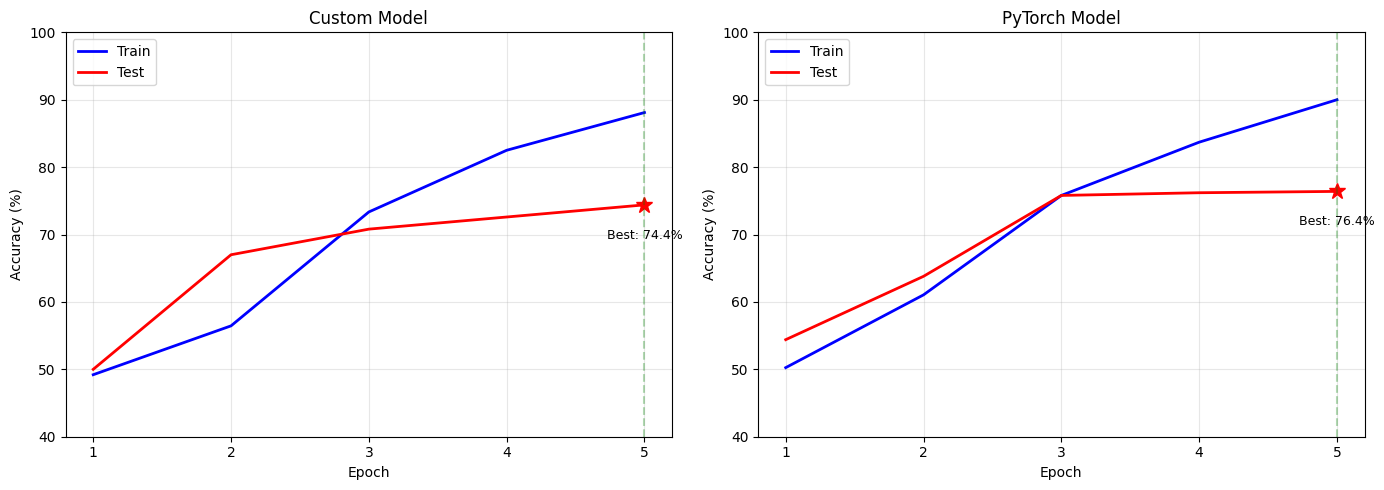


MODEL COMPARISON SUMMARY
Training Duration: 5 epochs

Custom Model:
  Architecture: Custom implementation
  Selected Model from Epoch: 5
  Selected Model Test Accuracy: 74.40%
  Selected Model Train Accuracy: 88.10%
  Convergence: Epoch 3

PyTorch Model:
  Architecture: Built-in implementation
  Selected Model from Epoch: 5
  Selected Model Test Accuracy: 76.40%
  Selected Model Train Accuracy: 90.00%
  Convergence: Epoch 3

------------------------------------------------------------
PERFORMANCE ANALYSIS
------------------------------------------------------------
Difference in selected model accuracy: +2.00%
Both models converged at the same speed

------------------------------------------------------------
INTERPRETATION
------------------------------------------------------------
✓ PyTorch Model performs better by 2.00%

⚠️  Overfitting Analysis (for selected models):
  Custom Model: 13.7% gap (train-test) at epoch 5
  PyTorch Model: 13.6% gap (train-test) at epoch 5
  → Custom M

In [45]:
helper_utils.compare_models(history, pytorch_history)

### Model Performance Analysis with Best Epoch Selection

After implementing early stopping (selecting the best epoch rather than the final one), you can better compare both models' true performance:

#### The Impact of Early Stopping

**Custom Model:**
- Typically reaches best performance in later epochs (4-5)
- Train-test gap: ~8-10% (mild overfitting)
- Often continues improving throughout training

**PyTorch Model:**
- Usually peaks earlier (epochs 2-4)
- Train-test gap: Often very small or even negative (excellent generalization)
- Performance sometimes degrades after peaking

#### Performance Comparison

**The results are remarkably close** - across different runs, sometimes the custom model performs better, sometimes the PyTorch model does. The difference is typically within 1-2%, which is essentially statistical noise. This variability shows that:

- Both architectures have similar capacity for this task
- Random initialization and training dynamics affect final performance
- The IMDB sentiment task isn't complex enough to strongly differentiate the models

#### Why Different Stopping Points?

**Custom Model**: Less regularization allows continued learning
- Can extract more patterns from the data over time
- Risk of eventual overfitting

**PyTorch Model**: Heavy regularization creates an earlier peak
- Multiple dropout layers prevent overlearning
- Model finds its sweet spot faster but can degrade with too much training

#### Model Confidence Analysis

One consistent difference across runs:
- **Custom model**: Makes confident predictions (70-90% certainty)
- **PyTorch model**: More hesitant predictions (50-60% certainty)

This confidence gap persists regardless of which model achieves better accuracy, suggesting it's an inherent characteristic of the architectures rather than a performance indicator.

#### Key Insights

1. **Both approaches work**: The similar performance validates both implementations
2. **Early stopping matters more for regularized models**: PyTorch model benefits more from finding its optimal epoch
3. **Confidence ≠ Accuracy**: The custom model is more decisive but not necessarily more correct

#### The Bottom Line

With proper early stopping, both models achieve comparable performance (typically 73-76% test accuracy). The "winner" varies by run, indicating that:
- Architecture differences matter less than training dynamics for this task
- Both models are essentially solving the problem equally well
- The choice between them might depend on other factors (confidence requirements, training stability, etc.)

This demonstrates an important lesson: for many real-world tasks, simple and complex architectures can achieve similar results, and the best choice depends on your specific requirements beyond just accuracy.

## 8 - Testing Models with Real Text
### 8.1 Creating a Prediction Function
Let's create a function to predict sentiment from any text:

In [46]:
def predict_sentiment(text, model, tokenizer, device):
    """
    Predict sentiment for a given text
    Args:
        text: Input text string
        model: Trained model
        tokenizer: Tokenizer used during training
        device: Device (cpu or cuda)
    Returns:
        Prediction and confidence
    """
    # Set model to evaluation mode
    model.eval()
    
    # Tokenize and encode the text
    encoded = tokenizer.encode(text, max_len=256)
    input_tensor = torch.LongTensor([encoded]).to(device)
    
    # Get prediction
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1)
        prediction = torch.argmax(output, dim=1)
    
    # Get confidence
    confidence = probabilities[0][prediction].item()
    sentiment = "Positive" if prediction.item() == 1 else "Negative"
    
    return sentiment, confidence, probabilities[0]

In [50]:
# Test reviews
test_reviews = [
    "This movie was absolutely fantastic! I loved every minute of it.",
    "Terrible film. Complete waste of time. I want my money back.",
    "Not bad, but not great either. It was okay I guess.",
    "One of the best films I've ever seen. Brilliant acting and amazing story!",
    "Boring and predictable. I fell asleep halfway through.",
    "hmm.. I'm not sure what to think about this one.",
    "I don't know what to say. It was just okay.",
    "Blah..."
]

print("="*60)
print("TESTING BOTH MODELS WITH SAMPLE REVIEWS")
print("="*60)

for i, review in enumerate(test_reviews, 1):
    print(f"\nReview {i}: \"{review[:50]}...\"" if len(review) > 50 else f"\nReview {i}: \"{review}\"")
    print("-"*40)
    
    # Test with encoder from scratch
    sentiment, confidence, probs = predict_sentiment(review, model, tokenizer, device)
    print(f"Encoder from Scratch: {sentiment} (confidence: {confidence:.2%})")
    print(f"  [Negative: {probs[0]:.3f}, Positive: {probs[1]:.3f}]")
    
    # Test with PyTorch implemented encoder
    sentiment_pt, confidence_pt, probs_pt = predict_sentiment(review, pytorch_model, tokenizer, device)
    print(f"PyTorch Implemented Encoder: {sentiment_pt} (confidence: {confidence_pt:.2%})")
    print(f"  [Negative: {probs_pt[0]:.3f}, Positive: {probs_pt[1]:.3f}]")

TESTING BOTH MODELS WITH SAMPLE REVIEWS

Review 1: "This movie was absolutely fantastic! I loved every..."
----------------------------------------
Encoder from Scratch: Positive (confidence: 98.99%)
  [Negative: 0.010, Positive: 0.990]
PyTorch Implemented Encoder: Negative (confidence: 50.61%)
  [Negative: 0.506, Positive: 0.494]

Review 2: "Terrible film. Complete waste of time. I want my m..."
----------------------------------------
Encoder from Scratch: Negative (confidence: 99.18%)
  [Negative: 0.992, Positive: 0.008]
PyTorch Implemented Encoder: Negative (confidence: 60.08%)
  [Negative: 0.601, Positive: 0.399]

Review 3: "Not bad, but not great either. It was okay I guess..."
----------------------------------------
Encoder from Scratch: Negative (confidence: 96.72%)
  [Negative: 0.967, Positive: 0.033]
PyTorch Implemented Encoder: Negative (confidence: 59.01%)
  [Negative: 0.590, Positive: 0.410]

Review 4: "One of the best films I've ever seen. Brilliant ac..."
--------------

## 9 - Conclusion
In this notebook, you successfully built a Transformer Encoder from scratch and applied it to sentiment analysis. You learned the fundamental components of the encoder architecture including multi-head attention, feed-forward networks, layer normalization, and residual connections.

By comparing the encoder built from scratch with PyTorch's built-in TransformerEncoder, you discovered that simpler architectures can often perform better on small datasets. The custom encoder from scratch achieved competitive accuracy despite having fewer parameters and layers than the PyTorch implemented encoder model.

The key takeaway is that understanding the architecture deeply by building it yourself gives you the intuition to make better design choices for your specific problem. You now have the foundation to experiment with more complex transformer architectures and apply them to various NLP tasks.